<a href="https://colab.research.google.com/github/solayman-cs/ML/blob/master/MNIST_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/DPP_Prac

/content/drive/My Drive/DPP_Prac


In [0]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [0]:
# Load the data
train_raw_data = pd.read_csv('train.csv')
test_raw_data = pd.read_csv('test.csv')

In [0]:
print(test_raw_data.head(5))
print(test_raw_data.shape)

   pixel0  pixel1  pixel2  pixel3  ...  pixel780  pixel781  pixel782  pixel783
0       0       0       0       0  ...         0         0         0         0
1       0       0       0       0  ...         0         0         0         0
2       0       0       0       0  ...         0         0         0         0
3       0       0       0       0  ...         0         0         0         0
4       0       0       0       0  ...         0         0         0         0

[5 rows x 784 columns]
(28000, 784)


In [0]:
print(train_raw_data.head(10))
print('\n Shape of the training dataset:', train_raw_data.shape)

   label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0  ...         0         0         0         0
1      0       0       0       0  ...         0         0         0         0
2      1       0       0       0  ...         0         0         0         0
3      4       0       0       0  ...         0         0         0         0
4      0       0       0       0  ...         0         0         0         0
5      0       0       0       0  ...         0         0         0         0
6      7       0       0       0  ...         0         0         0         0
7      3       0       0       0  ...         0         0         0         0
8      5       0       0       0  ...         0         0         0         0
9      3       0       0       0  ...         0         0         0         0

[10 rows x 785 columns]

 Shape of the training dataset: (42000, 785)


In [0]:
# Get labels
training_labels = train_raw_data['label']
# Drop label column
pure_image_data = train_raw_data.drop(labels='label', axis=1)
print(type(pure_image_data))
print(type(training_labels))
print('Pure image data shape: ', pure_image_data.shape)
print('Training label shape: ', training_labels.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Pure image data shape:  (42000, 784)
Training label shape:  (42000,)


In [0]:
# Check for null and missing values
pure_image_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

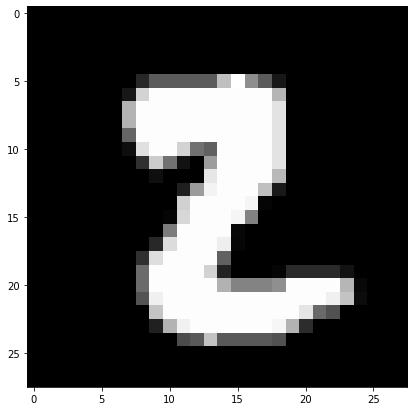

Label of the data: 2
Grid Datatype:  <class 'numpy.ndarray'>


In [0]:
plt.figure(figsize=(7,7))
i = 16

grid_data = pure_image_data.iloc[i].values.reshape(28,28)
plt.imshow(grid_data, interpolation = 'none', cmap = 'gray')
plt.show()

print('Label of the data:', training_labels[i])
print('Grid Datatype: ', type(grid_data))

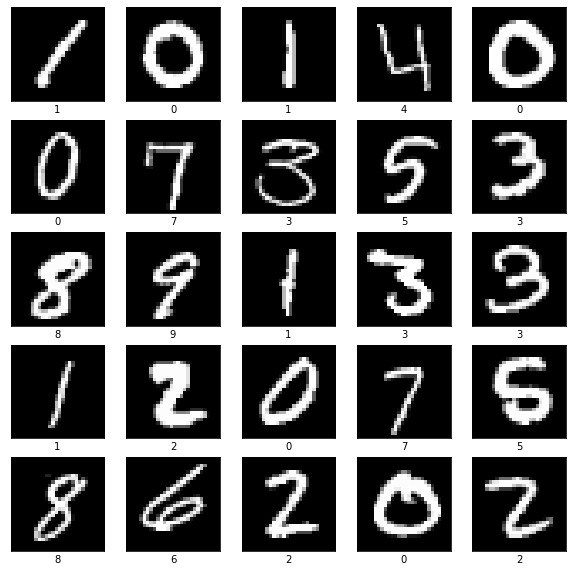

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    grid_data = pure_image_data.iloc[i].values.reshape(28,28)
    plt.imshow(grid_data, interpolation = 'none', cmap = 'gray')
    plt.xlabel(training_labels[i])

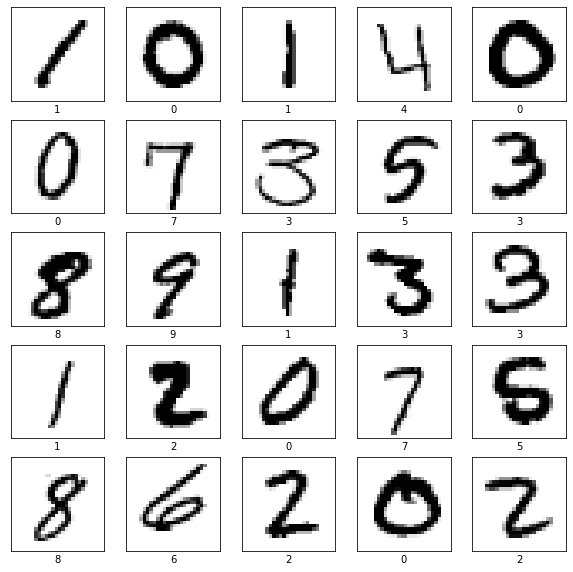

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    grid_data = pure_image_data.iloc[i].values.reshape(28,28)
    plt.imshow(grid_data, cmap=plt.cm.binary)
    plt.xlabel(training_labels[i])

In [0]:
# Normalize data
pure_image_data /= 255.0

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
training_images = pure_image_data.values.reshape(-1,28,28,1)

print('Training image shape: ', training_images.shape)
print('Training label shape: ', training_labels.shape)

Training image shape:  (42000, 28, 28, 1)
Training label shape:  (42000,)


In [0]:
# Split training and valdiation set
random_seed = 2

# (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.
training_images, validation_images, training_labels, validation_labels = train_test_split(training_images, training_labels, test_size = 0.35, random_state=random_seed)

**CNN Model**

In [0]:
# Parameters
epochs = 50
batch_size = 86

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
# Build Model
def CNN_model():
    
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                     activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                     activation ='relu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                     activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))


    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation = "softmax"))
    
    return model

model = CNN_model()    

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)         

In [0]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [0]:
# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(training_images)

In [0]:
history = model.fit_generator(
          datagen.flow(training_images, training_labels, batch_size=batch_size),
          epochs = epochs,
          validation_data = (validation_images, validation_labels),
          verbose = 2, 
          steps_per_epoch=training_images.shape[0] // batch_size,
          )

Epoch 1/50
317/317 - 13s - loss: 0.5092 - accuracy: 0.8321 - val_loss: 0.0754 - val_accuracy: 0.9772
Epoch 2/50
317/317 - 12s - loss: 0.1639 - accuracy: 0.9513 - val_loss: 0.0656 - val_accuracy: 0.9786
Epoch 3/50
317/317 - 13s - loss: 0.1157 - accuracy: 0.9652 - val_loss: 0.0411 - val_accuracy: 0.9880
Epoch 4/50
317/317 - 13s - loss: 0.1003 - accuracy: 0.9698 - val_loss: 0.0420 - val_accuracy: 0.9871
Epoch 5/50
317/317 - 13s - loss: 0.0883 - accuracy: 0.9731 - val_loss: 0.0330 - val_accuracy: 0.9893
Epoch 6/50
317/317 - 13s - loss: 0.0784 - accuracy: 0.9765 - val_loss: 0.0297 - val_accuracy: 0.9910
Epoch 7/50
317/317 - 13s - loss: 0.0688 - accuracy: 0.9797 - val_loss: 0.0299 - val_accuracy: 0.9918
Epoch 8/50
317/317 - 13s - loss: 0.0641 - accuracy: 0.9809 - val_loss: 0.0281 - val_accuracy: 0.9916
Epoch 9/50
317/317 - 13s - loss: 0.0596 - accuracy: 0.9826 - val_loss: 0.0271 - val_accuracy: 0.9916
Epoch 10/50
317/317 - 13s - loss: 0.0585 - accuracy: 0.9826 - val_loss: 0.0268 - val_accura

In [0]:
# Without Augmentation
history = model.fit(training_images, training_labels, epochs = 30, validation_data = (validation_images, validation_labels))

Epoch 1/30
854/854 [==============================] - 5s 6ms/step - loss: 0.2572 - accuracy: 0.9184 - val_loss: 0.0670 - val_accuracy: 0.9794
Epoch 2/30
854/854 [==============================] - 5s 6ms/step - loss: 0.0873 - accuracy: 0.9734 - val_loss: 0.0495 - val_accuracy: 0.9844
Epoch 3/30
854/854 [==============================] - 5s 6ms/step - loss: 0.0667 - accuracy: 0.9801 - val_loss: 0.0477 - val_accuracy: 0.9856
Epoch 4/30
854/854 [==============================] - 5s 6ms/step - loss: 0.0592 - accuracy: 0.9824 - val_loss: 0.0371 - val_accuracy: 0.9895
Epoch 5/30
854/854 [==============================] - 5s 6ms/step - loss: 0.0461 - accuracy: 0.9855 - val_loss: 0.0404 - val_accuracy: 0.9890
Epoch 6/30
854/854 [==============================] - 5s 6ms/step - loss: 0.0427 - accuracy: 0.9869 - val_loss: 0.0350 - val_accuracy: 0.9901
Epoch 7/30
854/854 [==============================] - 5s 6ms/step - loss: 0.0399 - accuracy: 0.9879 - val_loss: 0.0332 - val_accuracy: 0.9899
Epoch 

**Model Prediction & Save Result**

In [0]:
# Prediction 
classifications = model.predict(test_images)

In [0]:
i = 12
print(classifications[i])
maxpos = classifications[i].tolist().index(max(classifications[i]))
print('\nPredicted answer is: ', maxpos)

[1.3025762e-10 4.4817425e-05 3.1041989e-07 8.4716557e-05 9.8085862e-01
 1.1327190e-05 1.6935313e-07 1.0992746e-02 1.2320263e-04 7.8841448e-03]

Predicted answer is:  4


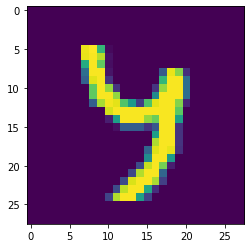

In [0]:
g = plt.imshow(test_images[i][:,:,0])

In [0]:
# Submission creation
def convert_prediction_result(model_result):
    result = []
    for i in range(len(model_result)):
        result += [np.argmax(model_result[i])]
    return result


def write_submission(_submission_path, result_arr):
    f_out = open(_submission_path, 'w')
    f_out.write("ImageId,Label\n")
    for i in range(len(result_arr)):
        f_out.write("{},{}\n".format(i+1, result_arr[i]))
    f_out.close()

write_submission('submission.csv', convert_prediction_result(classifications))

**History of CNN**

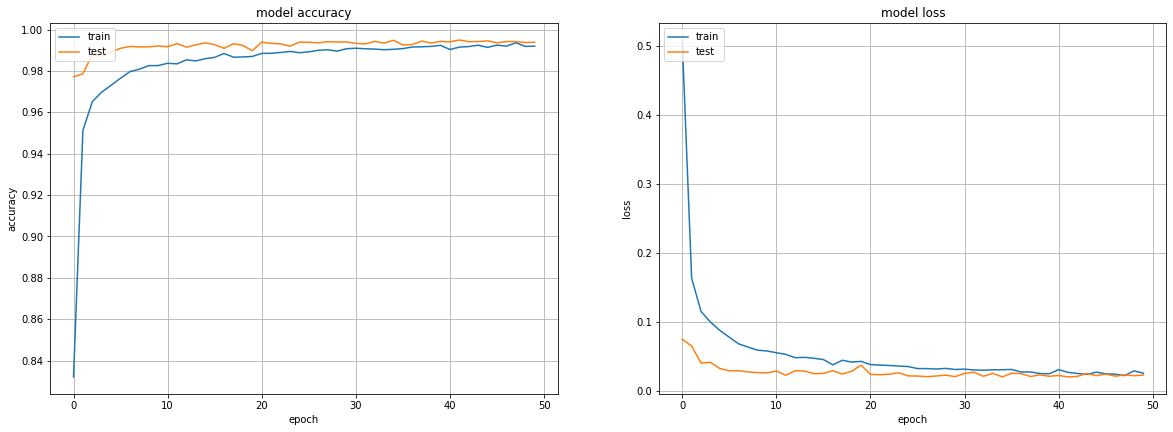

In [0]:
def plot_history(model_history):

    plt.figure(figsize = (20,15))
    
    plt.subplot(221)
    # summarize history for accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    
    plt.subplot(222)
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    plt.show()

plot_history(history)    

**Confusion Matrix**

In [0]:
plt.figure(figsize = (10,7))
# Predict the values from the validation dataset
y_pred = model.predict(validation_images.astype(np.float32))
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(validation_labels, axis = 1) 
# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(cm, classes = range(10))

NameError: ignored

<Figure size 720x504 with 0 Axes>

**Display Predicted Images**

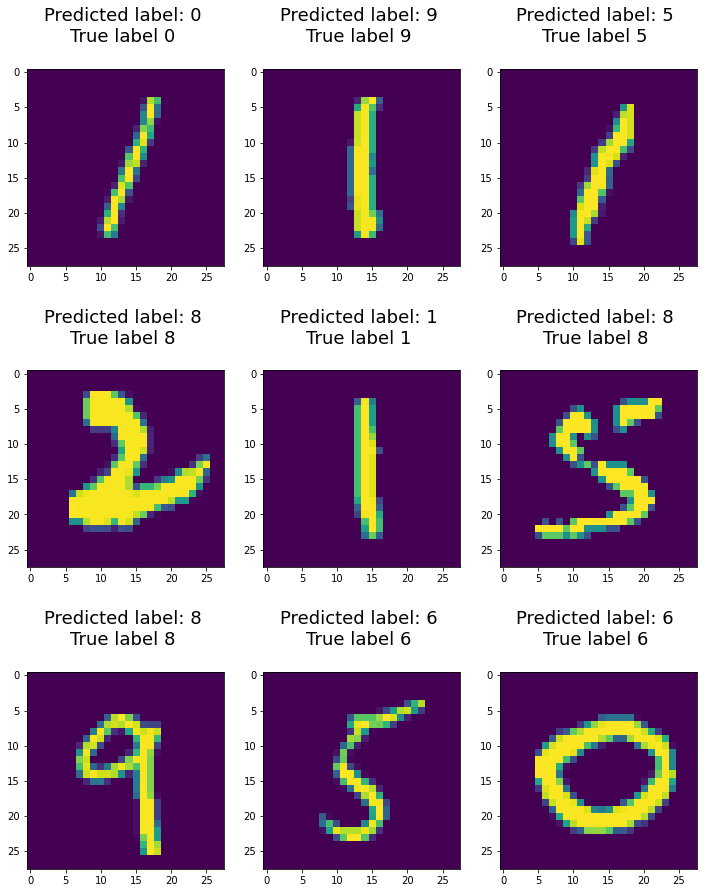

In [0]:
def display_predicted_images(graph_indexes = np.arange(9)):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    
    for graph_index in graph_indexes:
        
        index = random.randint(1, validation_images.shape[0])
        
        # Get corresponding label
        predicted_label = y_pred_classes[index]
        true_label = y_true[index]
        
        
        # define subplot
        plt.subplot(330 + 1 + graph_index)
        plt.title('Predicted label: %s \n'%predicted_label+\
                  'True label %s \n'%true_label,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(training_images[index][:,:,0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

display_predicted_images()    

**Display Errors**

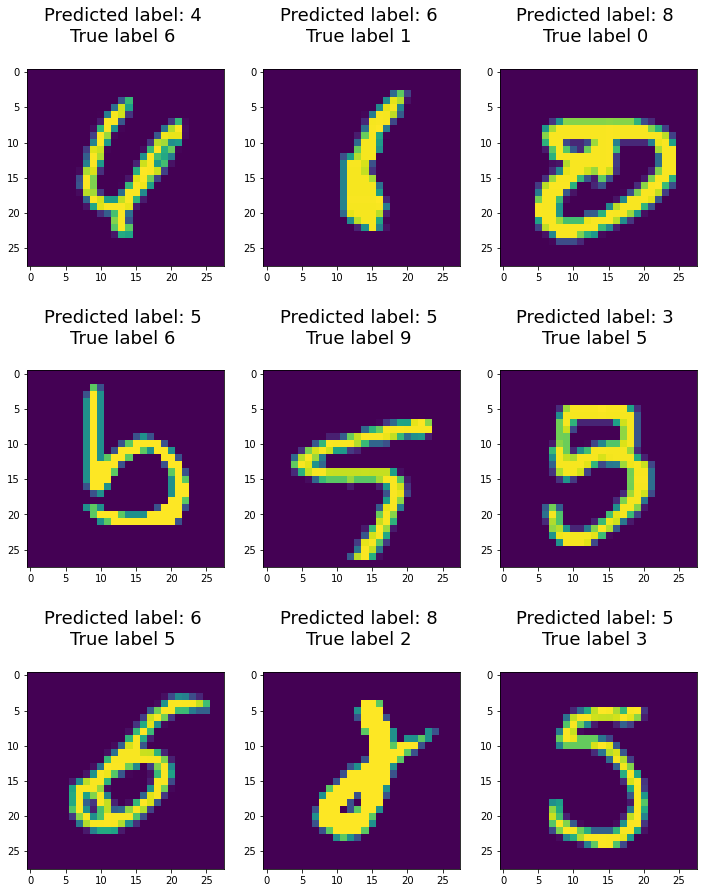

In [0]:
# Display errors 
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = validation_images[errors]

def display_top9_wrongly_predicted_images(list_of_indexes, graph_indexes = np.arange(9)):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    
    for graph_index in graph_indexes:
        
        index = list_of_indexes[graph_index]
        
        # Get corresponding label
        predicted_label = y_pred_classes_errors[index]
        true_label = y_true_errors[index]
        
        
        # define subplot
        plt.subplot(330 + 1 + graph_index)
        plt.title('Predicted label: %s \n'%predicted_label+\
                  'True label %s \n'%true_label,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(X_val_errors[index][:,:,0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 9 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 9 errors
display_top9_wrongly_predicted_images(list_of_indexes = most_important_errors)

**Data Preprocessing**

In [0]:
def Preprocessing(train, test, split_train_size = 0.35):

    #training_images = train.drop(["label"], axis = 1)
    #training_labels = train["label"]
    #test_images = test 

    training_images = train.iloc[:, 1:].values.astype('float32')     # all pixel values
    training_labels = train.iloc[:, 0].values.astype('float32')      # only labels i.e targets digits
    test_images = test.values.astype('float32')

    # Normalize the data
    training_images /= 255.0
    test_images /= 255.0

    # Reshape into right format vectors
    training_images = training_images.reshape(-1,28,28,1)
    test_images = test_images.reshape(-1,28,28,1)

    # Apply ohe on labels
    training_labels = to_categorical(training_labels, num_classes = 10)
    
    # Split the train and the validation set for the fitting
    training_images, validation_images, training_labels, validation_labels = train_test_split(training_images, training_labels, test_size = split_train_size, random_state=42)
    
    validation_images = validation_images.astype(np.float32)
    validation_labels = validation_labels.astype(np.float32)

    return training_images, validation_images, training_labels, validation_labels, test_images


training_images, validation_images, training_labels, validation_labels, test_images = Preprocessing(train_raw_data, test_raw_data)


In [0]:
predicted_values = model.predict(test_X)

In [0]:
my_submission = pd.DataFrame({'ImageId': test_raw_data.id, 'Label': predicted_values})
my_submission.to_csv('submission.csv', index=False)

In [0]:
# All pixel values
X_train = (train_raw_data.iloc[:, 1:].values).astype('float32')  
print(X_train[0, 100:150])
print('\n Shape of the training dataset', X_train.shape)
print(type(X_train))

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 188. 255.  94.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]

 Shape of the training dataset (42000, 784)
<class 'numpy.ndarray'>


In [0]:
# Normalize the data
X_train /= 255.0

In [0]:
# Print normalized data
print(X_train[0, 100:150])
print(X_train.shape)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.7372549  1.         0.36862746 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
(42000, 784)


In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = pure_data.values.reshape(-1,28,28,1)
print(X_train.shape)

(42000, 28, 28, 1)


In [0]:
# Getting the labels
y_train = train_raw_data['label']
print(y_train)
print('Type of the data: ', type(y_train))
print(y_train.shape)

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64
Type of the data:  <class 'pandas.core.series.Series'>
(42000,)


In [0]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
# Label Encoding
# Convert to one-hot-encoding 
y_train = to_categorical(y_train, num_classes=10)
print(y_train)
print(y_train.shape)
print(type(y_train))

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(42000, 10)
<class 'numpy.ndarray'>


In [0]:
# Split training and valdiation set
random_seed = 2

# Split the train and the validation set for the fitting
# (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)

In [0]:
# Build Model
model = tf.keras.models.Sequential([
     tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
     tf.keras.layers.Dense(128, activation=tf.nn.relu),
     tf.keras.layers.Dense(10, tf.nn.softmax)                             
])

In [0]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [0]:
model.fit(X_train, y_train, epochs=40)

Epoch 1/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1353 - accuracy: 0.9699
Epoch 2/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1365 - accuracy: 0.9672
Epoch 3/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1293 - accuracy: 0.9707
Epoch 4/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1253 - accuracy: 0.9716
Epoch 5/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1170 - accuracy: 0.9725
Epoch 6/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1299 - accuracy: 0.9725
Epoch 7/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1104 - accuracy: 0.9739
Epoch 8/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1298 - accuracy: 0.9726
Epoch 9/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1244 - accuracy: 0.9732
Epoch 10/40
1182/1182 [==============================] - 2s 2ms/step - loss: 0.119

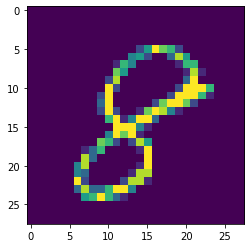

In [0]:
X_train = X_train.reshape(-1,28,28,1)
g = plt.imshow(X_train[0][:,:,0])